# Homework2

Team: AiCoders
Members:
* Alessio_Parato
* Jan31415


Task: The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future.

## Connection and Imports

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab Notebooks/Homework2/'
%cd /content/drive/MyDrive/Colab Notebooks/Homework2

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Homework2


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split

2.15.0


In [3]:
def save_model(model, model_name, path, mse=None, val_mse=None, mae=None, val_mae=None, plot=False):
  #
  #the functions saves the model and the history of a fit
  #
  if plot:
    tfk.utils.plot_model(model, to_file=path+'/model_pic.png', show_shapes=True, expand_nested=True)
  model.save(path+'/'+model_name)
  pd.DataFrame(mse).to_csv(path+'/'+model_name+'/mse.csv')
  pd.DataFrame(mae).to_csv(path+'/'+model_name+'/mae.csv')
  if val_mse!=None and val_mae!=None:
    pd.DataFrame(val_mse).to_csv(path+'/'+model_name+'/val_mse.csv')
    pd.DataFrame(val_mae).to_csv(path+'/'+model_name+'/val_mae.csv')

def load_model(path):
  #
  #the functions loads the model and the history of a fit
  #
  model = tfk.models.load_model(path)
  mse = pd.read_csv(path+'/mse.csv')
  val_mse = pd.read_csv(path+'/val_mse.csv')
  mae = pd.read_csv(path+'/mae.csv')
  val_mae = pd.read_csv(path+'/val_mae.csv')

  return (model, mse, val_mse, mae, val_mae)

## Load data

* 'training_data.npy': numpy array of shape (48000, 2776). 48000 time series of length 2776.
* 'valid_periods.npy': numpy array of type (48000, 2), containing for each of the time series the start and end index of the current series, i.e. the part without padding.
* 'categories.npy': numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.

In [ ]:
#loads the unzipped dataset and divides it into data and labels
t_d = np.load('Data/training_data.npy')
cate = np.load('Data/categories.npy')
v_p = np.load('Data/valid_periods.npy')
len_v_p = v_p[:,1]-v_p[:,0]
# Print shapes of the datasets
print(f"training shape: {t_d.shape}")
print(f"categories shape: {cate.shape}")
print(f"valid_periods shape: {v_p.shape}")

training shape: (48000, 2776)
categories shape: (48000,)
valid_periods shape: (48000, 2)


### Process the dataset


In [ ]:
A = np.reshape((np.where(cate=='A')), 5728)
A_train, A_v_p, A_len_v_p = t_d[A], v_p[A], len_v_p[A]
B = np.reshape((np.where(cate=='B')), 10987)
B_train, B_v_p, B_len_v_p = t_d[B], v_p[B], len_v_p[B]
C = np.reshape((np.where(cate=='C')), 10017)
C_train, C_v_p, C_len_v_p = t_d[C], v_p[C], len_v_p[C]
D = np.reshape((np.where(cate=='D')), 10016)
D_train, D_v_p, D_len_v_p = t_d[D], v_p[D], len_v_p[D]
E = np.reshape((np.where(cate=='E')), 10975)
E_train, E_v_p, E_len_v_p = t_d[E], v_p[E], len_v_p[E]
F = np.reshape((np.where(cate=='F')), 277)
F_train, F_v_p, F_len_v_p = t_d[F], v_p[F], len_v_p[F]

### Split in train, validation and test

* Training set
* Validation set
* Test set

In [ ]:
def build_sequences(data, valid_periods, window=200, telescope=9, step=209):
    dataset = []
    labels = []
    da = data.copy()
    va_p = valid_periods.copy()

    for i in range(da.shape[0]):
      series = da[i,va_p[i,0]:va_p[i,1]]
      idx = 0
      while(idx+window+telescope < series.shape[0]):
        dataset.append(series[idx:idx+window])
        labels.append(series[idx+window:idx+window+telescope])
        idx = idx+step

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels
def build_sequences2(data, window=200, telescope=9, step=209):
    dataset = []
    labels = []
    da = data.copy()

    for series in da:
      idx = 0
      while(idx+window+telescope < series.shape[0]):
        dataset.append(series[idx:idx+window])
        labels.append(series[idx+window:idx+window+telescope])
        idx = idx+step

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
A_x, A_y = build_sequences(t_d[A], v_p[A], telescope=18, step=77)
print(f'Number of Training: {A_x.shape[0]}')
B_x, B_y = build_sequences(t_d[B], v_p[B],telescope=18, step=77)
print(f'Number of Training: {B_x.shape[0]}')
C_x, C_y = build_sequences(t_d[C], v_p[C],telescope=18, step=77)
print(f'Number of Training: {C_x.shape[0]}')
D_x, D_y = build_sequences(t_d[D], v_p[D],telescope=18, step=77)
print(f'Number of Training: {D_x.shape[0]}')
E_x, E_y = build_sequences(t_d[E], v_p[E],telescope=18, step=77)
print(f'Number of Training: {E_x.shape[0]}')
F_x, F_y = build_sequences(t_d[F], v_p[F],telescope=18, step=77)
print(f'Number of Training: {F_x.shape[0]}')

Number of Training: 6765
Number of Training: 5018
Number of Training: 7630
Number of Training: 9801
Number of Training: 6296
Number of Training: 196


In [ ]:
test_size = 0.2
Ax_t_v, Ax_t, Ay_t_v, Ay_t = train_test_split(A_x, A_y, random_state=seed, test_size=test_size)
Bx_t_v, Bx_t, By_t_v, By_t = train_test_split(B_x, B_y, random_state=seed, test_size=test_size)
Cx_t_v, Cx_t, Cy_t_v, Cy_t = train_test_split(C_x, C_y, random_state=seed, test_size=test_size)
Dx_t_v, Dx_t, Dy_t_v, Dy_t = train_test_split(D_x, D_y, random_state=seed, test_size=test_size)
Ex_t_v, Ex_t, Ey_t_v, Ey_t = train_test_split(E_x, E_y, random_state=seed, test_size=test_size)
Fx_t_v, Fx_t, Fy_t_v, Fy_t = train_test_split(F_x, F_y, random_state=seed, test_size=test_size)

In [ ]:
t_list = []
for i in range(t_d.shape[0]):
  t_list.append(t_d[i,v_p[i,0]:])
t_cor_l = []
for ele in t_list:
  t_cor_l.append(np.correlate(ele, ele))
t_cor_l = np.array(t_cor_l)

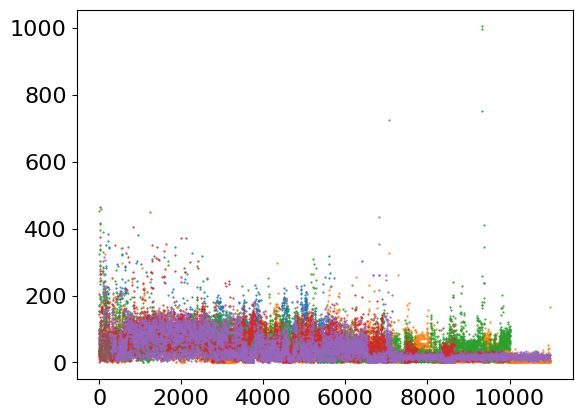

In [ ]:
s = 0.3
plt.scatter(range(t_cor_l[A].shape[0]),t_cor_l[A], s=s)
plt.scatter(range(t_cor_l[B].shape[0]),t_cor_l[B], s=s)
plt.scatter(range(t_cor_l[C].shape[0]),t_cor_l[C], s=s)
plt.scatter(range(t_cor_l[D].shape[0]),t_cor_l[D], s=s)
plt.scatter(range(t_cor_l[E].shape[0]),t_cor_l[E], s=s)
plt.scatter(range(t_cor_l[F].shape[0]),t_cor_l[F], s=s)
plt.show()

In [ ]:
tx, ty = build_sequences2(t_list, window=200, telescope=18, step=200)
print(tx.shape)

(23016, 200)


# Plan 1 - Connecting

The plan was to recreate the attention model from the class. Now the question was: What should we put as an input or where should we add our trained model?
We decided to add our model in the front of the Encoder and Decoder. Then the encoder can concentrate on the 18 points and decide which are important.
To do so we loaded our at this moment best model and builded the attention model.
For the training we decided again to train with all categories simultaneously first and then with each category individually.
On the test set we got good results but not at the online submission.

In [4]:
model = load_model('Cate/model2')[0]
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
model.trainable = False
model.summary()

Model: "simp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv1 (Conv1D)              (None, 200, 32)           352       
                                                                 
 conv2 (Conv1D)              (None, 200, 32)           10272     
                                                                 
 avg1 (AveragePooling1D)     (None, 66, 32)            0         
                                                                 
 conv3 (Conv1D)              (None, 66, 64)            20544     
                                                                 
 conv4 (Conv1D)              (None, 66, 64)            41024     
                                                                 
 avg2 (AveragePooling1D)     (None, 22, 64)            0

In [5]:
def build_model(model):
  input_size = (200,1)
  output_size = 18

  dense_dim = 200
  embed_dim = 18
  latent_dim = 100
  num_heads = 8

  coder_input_size = (18,1)

  input = tfk.Input(shape=input_size, name='INPUT')
  x = tf.expand_dims(model(input), axis=2)

  dense_proj = tfk.Sequential([tfkl.Dense(dense_dim, activation='relu'), tfkl.Dense(embed_dim),])

  attention_output = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(query=x, value=x, key=x)
  proj_input = tfkl.LayerNormalization(name='Norm1')(x + attention_output)
  proj_output = dense_proj(proj_input)
  enc = tfkl.LayerNormalization(name='Norm2')(proj_input + proj_output)


  attention_output = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(query=x,value=enc,key=enc)
  out_1 = x + attention_output
  gap = tfkl.GlobalAveragePooling1D(name='gap')(out_1)
  rel = tfk.activations.relu(gap)
  dense_out = tfkl.Dense(100, activation='relu', name='Dense1')(rel)
  dense_out = tfkl.Dense(18)(rel)

  return tfk.Model(input, dense_out, name='transformer')

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 simp_model (Functional)     (None, 18)                   320530    ['INPUT[0][0]']               
                                                                                                  
 tf.expand_dims_1 (TFOpLamb  (None, 18, 1)                0         ['simp_model[1][0]']          
 da)                                                                                              
                                                                                                  
 multi_head_attention_2 (Mu  (None, 18, 1)                1009      ['tf.expand_dims_1[0

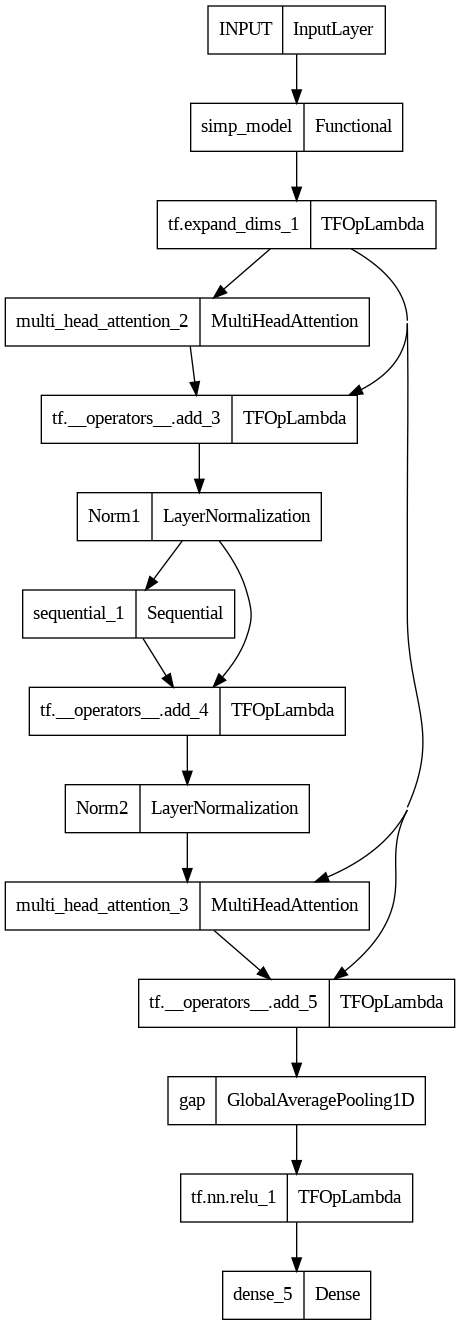

In [7]:
trans = build_model(model)
trans.compile('adam', loss='mse', metrics=['mse', 'mae'])
trans.summary()
tfk.utils.plot_model(trans, to_file='Attention/Attention_Plan1/model.png')

In [ ]:
history = trans.fit(
    x = tx,
    y = ty,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.15, min_lr=1e-5)
    ]
).history

Epoch 1/200
162/162 [==============================] - 25s 131ms/step - loss: 0.0687 - mse: 0.0687 - mae: 0.1992 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1453 - lr: 0.0010
Epoch 2/200
162/162 [==============================] - 25s 153ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.1003 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0876 - lr: 0.0010
Epoch 3/200
162/162 [==============================] - 19s 120ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0654 - val_loss: 0.0132 - val_mse: 0.0132 - val_mae: 0.0771 - lr: 0.0010
Epoch 4/200
162/162 [==============================] - 19s 120ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0608 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0749 - lr: 0.0010
Epoch 5/200
162/162 [==============================] - 22s 139ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0597 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0747 - lr: 0.0010
Epoch 6/200
162/162 [==============================] - 19s 120ms/step - loss: 0.0076 - mse: 0.0

In [ ]:
save_model(trans, 'model1', 'Attention/Attention_Plan1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

In [ ]:
trans = load_model('Attention/Attention_Plan1/model1')[0]
trans.compile(loss='mae', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
history = trans.fit(
    x = tx,
    y = ty,
    batch_size = 64,
    epochs = 200,
    validation_split=.1,
    callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.15, min_lr=1e-5)]
).history
save_model(trans, 'model2', 'Attention/Attention_Plan1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

Epoch 1/200
324/324 [==============================] - 16s 44ms/step - loss: 0.0450 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0679 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 2/200
324/324 [==============================] - 11s 32ms/step - loss: 0.0450 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0679 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 3/200
324/324 [==============================] - 12s 38ms/step - loss: 0.0450 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0679 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 4/200
324/324 [==============================] - 14s 42ms/step - loss: 0.0450 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0679 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 5/200
324/324 [==============================] - 13s 40ms/step - loss: 0.0450 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0679 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 6/200
324/324 [==============================] - 13s 39ms/step - loss: 0.0450 - mse: 0.0047 - 

In [ ]:
trans = load_model('Attention/Attention_Plan1/model2')[0]
trans.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001), metrics=['mse', 'mae'])
history = trans.fit(
    x = tx,
    y = ty,
    batch_size = 32,
    epochs = 200,
    validation_split=.1,
    callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.15, min_lr=1e-5)]
).history

Epoch 1/200
648/648 [==============================] - 15s 22ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 2/200
648/648 [==============================] - 14s 22ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 3/200
648/648 [==============================] - 14s 22ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 4/200
648/648 [==============================] - 13s 20ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 5/200
648/648 [==============================] - 22s 33ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0450 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0679 - lr: 0.0010
Epoch 6/200
648/648 [==============================] - 15s 23ms/step - loss: 0.0047 - mse: 0.0047 - 

In [ ]:
save_model(trans, 'model2', 'Attention/Attention_Plan1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

# Training

In [ ]:
def training(init_model, cate, cate_name, step1, step2, test_size = 0.2):
  x, y = build_sequences(t_d[cate], v_p[cate], window=200, telescope=18, step = step1)
  print(f'Number of Training: {x.shape[0]}')
  x_t_v, x_t, y_t_v, y_t = train_test_split(x, y, random_state=seed, test_size=test_size)
  model = load_model(init_model)[0]
  model.trainable=True
  model.compile(loss='mse', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
  history = model.fit(
    x = x_t_v,
    y = y_t_v,
    batch_size = 128, epochs = 200, validation_split=.1,
    callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
  save_model(model, 'model1_'+cate_name, 'Attention/Attention_Plan1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
  del model
  model = load_model('Attention/Attention_Plan1/model1_'+cate_name)[0]
  model.compile(loss='mse', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
  history = model.fit(
    x = x_t_v,
    y = y_t_v,
    batch_size = 64, epochs = 200, validation_split=.1,
    callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
  save_model(model, 'model2_'+cate_name, 'Attention/Attention_Plan1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
  del model

  model = load_model('Attention/Attention_Plan1/model2_'+cate_name)[0]
  model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001), metrics=['mse', 'mae'])
  x, y = build_sequences(t_d[cate], v_p[cate], window=200, telescope=18, step = step2)
  print(f'Number of Training: {x.shape[0]}')
  x_t_v, x_t, y_t_v, y_t = train_test_split(x, y, random_state=seed, test_size=test_size)

  history = model.fit(
    x = x_t_v,
    y = y_t_v,
    batch_size = 64, epochs = 200, validation_split=.1,
    callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
  ).history
  save_model(model, 'model3_'+cate_name, 'Attention/Attention_Plan1', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

## Cate A

In [ ]:
training('Attention/Attention_Plan1/model2', A, 'A', 150, 90, test_size = 0.2)

Number of Training: 5062
Epoch 1/200
29/29 [==============================] - 17s 485ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0531 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0478 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 10s 326ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0456 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0484 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 12s 430ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0449 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0462 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 13s 463ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0433 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0468 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 15s 525ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0415 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0458 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 12s 397ms/step - loss: 0.00

## Cate B

In [ ]:
training('Attention/Attention_Plan1/model2', B, 'B', 80, 60, test_size = 0.2)

Number of Training: 4944
Epoch 1/200
28/28 [==============================] - 12s 396ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0725 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0633 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - 8s 276ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0641 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0638 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - 10s 346ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0617 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0622 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - 7s 244ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0602 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0635 - lr: 0.0010
Epoch 5/200
28/28 [==============================] - 10s 350ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0594 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0630 - lr: 0.0010
Epoch 6/200
28/28 [==============================] - 7s 249ms/step - loss: 0.0078 

## Cate C

In [ ]:
training('Attention/Attention_Plan1/model2', C, 'C', 150, 95, test_size = 0.2)

Number of Training: 5201
Epoch 1/200
30/30 [==============================] - 9s 256ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0575 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0528 - lr: 0.0010
Epoch 2/200
30/30 [==============================] - 10s 329ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0522 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0540 - lr: 0.0010
Epoch 3/200
30/30 [==============================] - 8s 267ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0515 - val_loss: 0.0063 - val_mse: 0.0063 - val_mae: 0.0540 - lr: 0.0010
Epoch 4/200
30/30 [==============================] - 9s 308ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0495 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0514 - lr: 0.0010
Epoch 5/200
30/30 [==============================] - 8s 279ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0460 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0518 - lr: 0.0010
Epoch 6/200
30/30 [==============================] - 9s 290ms/step - loss: 0.0044 - 

## Cate D

In [ ]:
training('Attention/Attention_Plan1/model2', D, 'D', 150, 100, test_size = 0.2)

Number of Training: 6777
Epoch 1/200
39/39 [==============================] - 13s 280ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0551 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0499 - lr: 0.0010
Epoch 2/200
39/39 [==============================] - 12s 305ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0498 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0519 - lr: 0.0010
Epoch 3/200
39/39 [==============================] - 12s 322ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0487 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0509 - lr: 0.0010
Epoch 4/200
39/39 [==============================] - 12s 304ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0483 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0504 - lr: 0.0010
Epoch 5/200
39/39 [==============================] - 12s 312ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0475 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0584 - lr: 0.0010
Epoch 6/200
39/39 [==============================] - 10s 255ms/step - loss: 0.00

## Cate E

In [ ]:
training('Attention/Attention_Plan1/model2', E, 'E', 150, 100, test_size = 0.2)

Number of Training: 4630
Epoch 1/200
27/27 [==============================] - 10s 303ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0468 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0444 - lr: 0.0010
Epoch 2/200
27/27 [==============================] - 8s 284ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0422 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0442 - lr: 0.0010
Epoch 3/200
27/27 [==============================] - 7s 271ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0411 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0479 - lr: 0.0010
Epoch 4/200
27/27 [==============================] - 12s 443ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0400 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0466 - lr: 0.0010
Epoch 5/200
27/27 [==============================] - 7s 257ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0391 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0472 - lr: 0.0010
Epoch 6/200
27/27 [==============================] - 8s 306ms/step - loss: 0.0030 -

## Cate F

In [ ]:
training('Attention/Attention_Plan1/model2', F, 'F', 10, 5, test_size = 0.2)

Number of Training: 1245
Epoch 1/200
7/7 [==============================] - 5s 464ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0487 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0467 - lr: 0.0010
Epoch 2/200
7/7 [==============================] - 2s 254ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0379 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0465 - lr: 0.0010
Epoch 3/200
7/7 [==============================] - 2s 253ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0351 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0458 - lr: 0.0010
Epoch 4/200
7/7 [==============================] - 2s 254ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0325 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0421 - lr: 0.0010
Epoch 5/200
7/7 [==============================] - 2s 255ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0299 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0401 - lr: 0.0010
Epoch 6/200
7/7 [==============================] - 2s 253ms/step - loss: 0.0036 - mse: 0.0036 -

# Validation

In [ ]:
model = load_model('Attention/Attention_Plan1/model2')[0]
print(f'Model2; Cate A:{model.evaluate(Ax_t, Ay_t, verbose=0)}')
print(f'Model2; Cate B:{model.evaluate(Bx_t, By_t, verbose=0)}')
print(f'Model2; Cate C:{model.evaluate(Cx_t, Cy_t, verbose=0)}')
print(f'Model2; Cate D:{model.evaluate(Dx_t, Dy_t, verbose=0)}')
print(f'Model2; Cate E:{model.evaluate(Ex_t, Ey_t, verbose=0)}')
print(f'Model2; Cate F:{model.evaluate(Fx_t, Fy_t, verbose=0)}')

modelA = load_model('Attention/Attention_Plan1/model3_A')[0]
print(f'Cate A:{modelA.evaluate(Ax_t, Ay_t, verbose=0)}')
modelB = load_model('Attention/Attention_Plan1/model3_B')[0]
print(f'Cate B:{modelB.evaluate(Bx_t, By_t, verbose=0)}')
modelC = load_model('Attention/Attention_Plan1/model3_C')[0]
print(f'Cate C:{modelC.evaluate(Cx_t, Cy_t, verbose=0)}')
modelD = load_model('Attention/Attention_Plan1/model3_D')[0]
print(f'Cate D:{modelD.evaluate(Dx_t, Dy_t, verbose=0)}')
modelE = load_model('Attention/Attention_Plan1/model3_E')[0]
print(f'Cate E:{modelE.evaluate(Ex_t, Ey_t, verbose=0)}')
modelF = load_model('Attention/Attention_Plan1/model3_F')[0]
print(f'Cate F:{modelF.evaluate(Fx_t, Fy_t, verbose=0)}')

Model2; Cate A:[0.005395933985710144, 0.005395933985710144, 0.05062131956219673]
Model2; Cate B:[0.01083130668848753, 0.01083130668848753, 0.06436609476804733]
Model2; Cate C:[0.007284738589078188, 0.007284738589078188, 0.05596916750073433]
Model2; Cate D:[0.007261027116328478, 0.007261027116328478, 0.05589313805103302]
Model2; Cate E:[0.006190949585288763, 0.006190949585288763, 0.05012274533510208]
Model2; Cate F:[0.010768625885248184, 0.010768625885248184, 0.057763420045375824]
Cate A:[0.004112517461180687, 0.004112517461180687, 0.0425376296043396]
Cate B:[0.007810348644852638, 0.007810348644852638, 0.05227351561188698]
Cate C:[0.006279123015701771, 0.006279123015701771, 0.04946774244308472]
Cate D:[0.006143788807094097, 0.006143788807094097, 0.0493631549179554]
Cate E:[0.005029665306210518, 0.005029665306210518, 0.04153698682785034]
Cate F:[0.002752110594883561, 0.002752110594883561, 0.020783092826604843]
